# Pricing Algorithm for Daniel Ershov's Study

This is a notebook where I conduct exploratory data analysis on the training data provided by Daniel Ershov for his study.

### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import model
import scipy.optimize as opt

## Showcasing the script with the model

In [3]:
data = pd.read_csv('data/output_data.csv')

# Process data for training
data = model.process_training_data(data)

# Train model
models = model.train_model(data)

In [4]:
testing_data = data.copy()

# Get only columns we need for testing
testing_data = testing_data[['mkt_id','output_own_cost', 'output_X']]

# Process data for testing
testing_data = model.process_testing_data(testing_data)

In [7]:
# Get predictions -- returns optimal price and expected profit
model.predict_price(testing_data.loc[0], models)

(array([7.72598277]), array([18.0535404]))

Let's check out how the model does over the whole dataset.

Mean difference in expected profits:  1.0848112788225952
Variance of difference in expected profits:  7.151198084752198


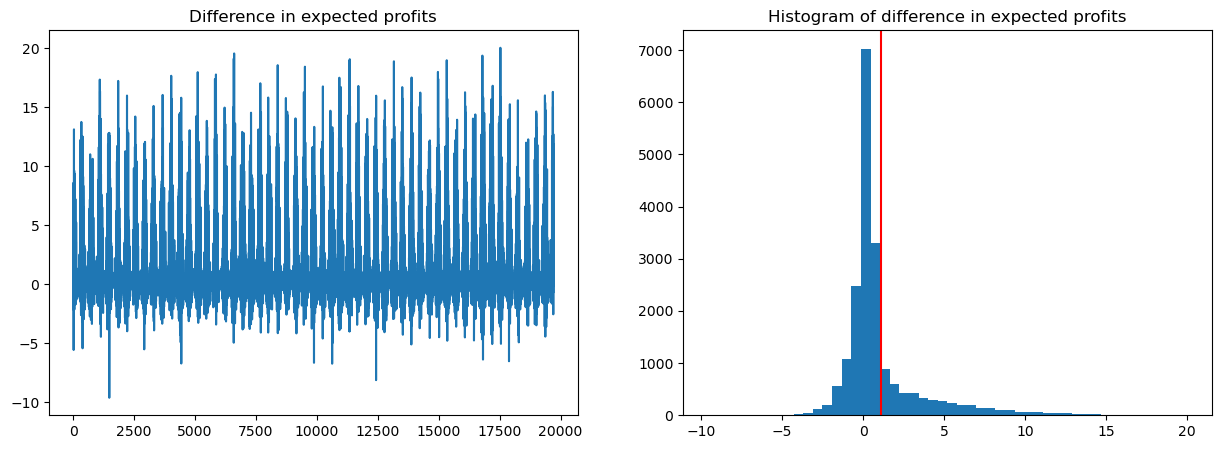

In [6]:
# Get expected profits for the whole dataset
expected_profits = model.predict_price(testing_data, models)[1]
exp_diff_in_profits = expected_profits - data['output_own_profits']

print("Mean difference in expected profits: ", np.mean(exp_diff_in_profits))
print("Variance of difference in expected profits: ", np.var(exp_diff_in_profits))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(exp_diff_in_profits);
ax[1].hist(exp_diff_in_profits, bins=50);
ax[0].set_title('Difference in expected profits');
ax[1].set_title('Histogram of difference in expected profits');
ax[1].axvline(np.mean(exp_diff_in_profits), 0, 1000, color='red', label='Mean');


# Work that went into this notebook

First, we load the data and take a look at it.

In [9]:
data = pd.read_csv('data/output_data.csv')
num_cols = data.select_dtypes(include='number')

In [10]:
data

,mkt_id,output_date,output_own_price,output_own_cost,output_comp_price,output_own_profits,output_X,output_own_share,output_own_sales
0,44,01jan2019,7.05,5.90,7.11,15.065000,42.80,0.515267,13.10
1,44,02jan2019,7.05,6.05,7.11,24.310000,36.14,0.557082,24.31
2,44,03jan2019,7.05,5.98,7.28,30.783910,34.34,0.579922,28.77
3,44,04jan2019,7.05,5.98,7.28,20.169500,36.32,0.542767,18.85
4,44,05jan2019,6.79,6.07,6.68,1.231200,44.06,0.494757,1.71
...,...,...,...,...,...,...,...,...,...
19705,15555,27dec2019,7.28,5.96,7.30,26.070000,36.68,0.515118,19.75
19706,15555,28dec2019,6.69,5.94,6.64,3.720000,34.34,0.497312,4.96
19707,15555,29dec2019,6.69,5.91,6.64,3.393001,32.00,0.424593,4.35
19708,15555,30dec2019,7.31,5.99,7.42,31.561200,31.10,0.465712,23.91


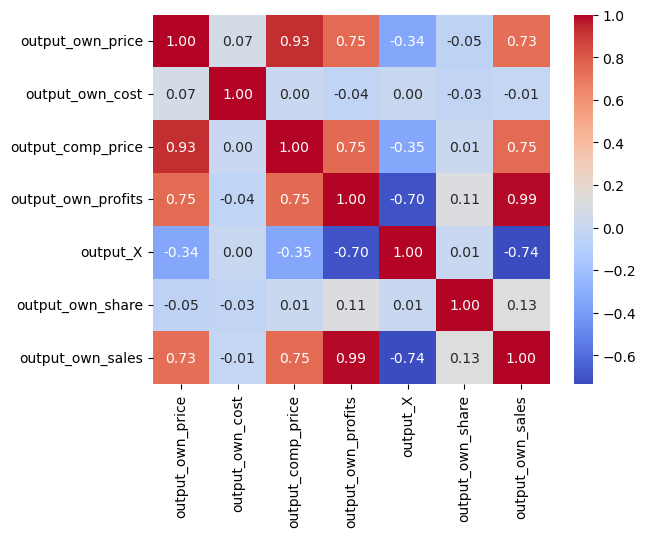

In [12]:
# Calculate correlation matrix
corr_matrix = num_cols.corr().drop('mkt_id', axis=1).drop('mkt_id', axis=0)

# Create heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Show plot
plt.show()

Now let's create some new features.

In [14]:
data['price_diff'] = data['output_own_price'] - data['output_comp_price']
data['total_sales'] = data['output_own_sales'] / data['output_own_share']

for i in data['mkt_id'].unique():
    data.loc[data['mkt_id'] == i, 'index_day_of_year'] = range(1, len(data.loc[data['mkt_id'] == i])+1)

data['bool_week_day'] = data['index_day_of_year'].apply(lambda x: 1 if (((x + 1) % 7 < 6) and ((x + 1) % 7 != 0)) else 0)

## Modelling total sales

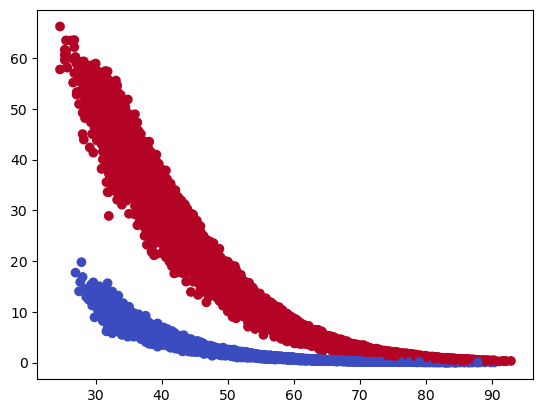

In [16]:
data_for_plot = data
plt.scatter(data_for_plot['output_X'], data_for_plot['total_sales'], c=data_for_plot['bool_week_day'], cmap='coolwarm')

Text(0, 0.5, 'Market Conditions')

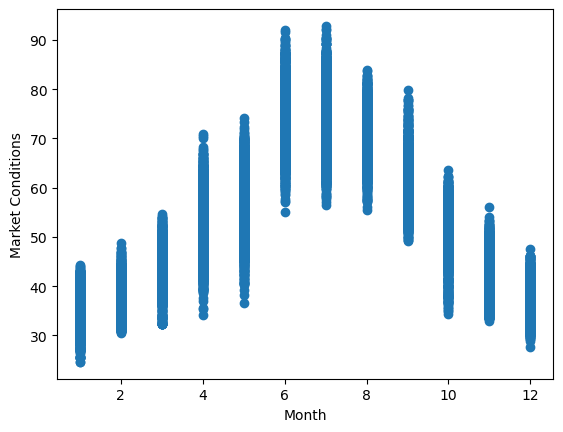

In [17]:
# Don't need as market conditions is given
plt.scatter(data['index_month'], data['output_X'])
plt.xlabel('Month')
plt.ylabel('Market Conditions')

# Model 1: maximising share of total profit

!! Doesn't take into account that changing the price changes the total sales, assumes total sales is out of control.

In [18]:
# Sigmoid mu Normal MLE
def log_likelihood(params):
    # params = [beta_0, beta_1, beta_2, beta_3, sigma]
    mu = 1/ (1 + np.exp(-( params[0] + params[1] * data['bool_week_day'] + params[2] * data['price_diff'] + params[3] * data['price_diff'] * data['bool_week_day'])))
    sigma = params[4]
    n = len(data)
    ll = n/2 * np.log(sigma**2 * 2 * np.pi) + 1/ (2 * sigma**2) * sum((data['output_own_share'] - mu)**2)
    return ll

params_init = np.array([1, 1, 1, 1, 1])
results_mle = opt.minimize(log_likelihood, params_init)

results_mle.x

array([ 2.55108355e-04, -2.90864928e-03, -1.27492271e+00,  7.55555683e-01,
        7.65929547e-02])

Text(0.5, 0, 'Price Difference')

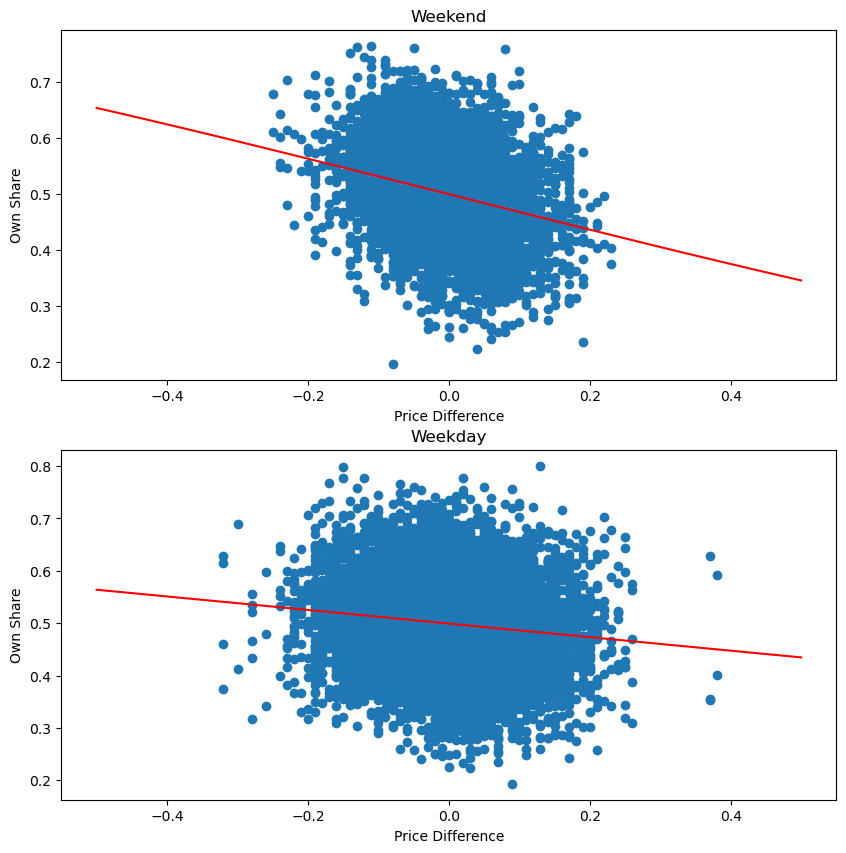

In [19]:
data_weekend = data.loc[data['bool_week_day'] == 0]
data_weekday = data.loc[data['bool_week_day'] == 1]
line = np.linspace(-0.5, 0.5, 100)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].scatter(data_weekend['price_diff'], data_weekend['output_own_share'])
ax[0].plot(line, 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[2] * line))), 'r')
ax[0].set_title('Weekend')
ax[0].set_ylabel('Own Share')
ax[0].set_xlabel('Price Difference')

ax[1].scatter(data_weekday['price_diff'], data_weekday['output_own_share'])
ax[1].plot(line, 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[1] + (results_mle.x[2] + results_mle.x[3]) * line))), 'r')
ax[1].set_title('Weekday')
ax[1].set_ylabel('Own Share')
ax[1].set_xlabel('Price Difference')

In [20]:
try_cost = 6

def model_one_price(cost, weekday):
    if weekday:
        return -1/(results_mle.x[2] + results_mle.x[3]) + cost
    return -1/results_mle.x[2] + cost

model_one_price(try_cost, weekday=0)

6.784361270760066

# Exploring the two splits (weekdays and weekends)

Intercept:  13.089977843128963
Coefficients:  [ 1.71378128e+01 -8.43447972e-01  1.79714555e-02 -1.97300062e-04
  1.10303766e-06 -2.50154153e-09 -5.78773741e+00 -3.30399835e+00]
R^2:  0.9789242149855613


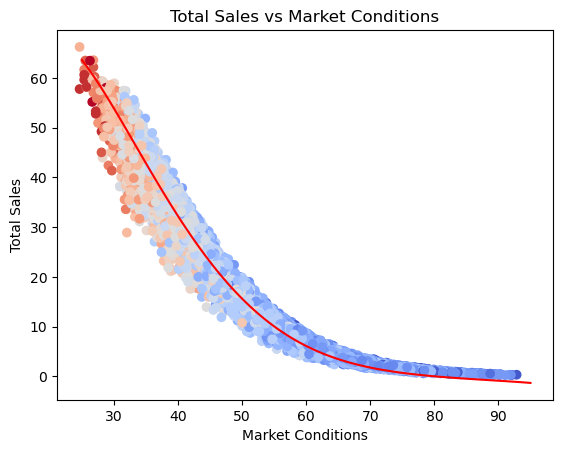

In [21]:
# Linear regression y=TS
# Note: make output_x**3 part of X
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Regression on weekdays
data_to_reg = data.loc[data['bool_week_day'] == 1]

degree = 6
poly = PolynomialFeatures(degree)
output_X_poly = np.array(poly.fit_transform(data_to_reg['output_X'].values.reshape(-1, 1)))

X = np.concatenate((output_X_poly[:, 1:], data_to_reg['output_own_price'].values.reshape(-1, 1), data_to_reg['output_comp_price'].values.reshape(-1, 1)), axis=1)
y = data_to_reg['total_sales']

reg_weekdays = LinearRegression().fit(X, y)

print('Intercept: ', reg_weekdays.intercept_)
print('Coefficients: ', reg_weekdays.coef_)
print('R^2: ', reg_weekdays.score(X, y))

# Plot
data_to_plot = data.loc[data['bool_week_day'] == 1]
plt.scatter(data_to_plot['output_X'], data_to_plot['total_sales'], c=data_to_plot['output_own_price'], cmap='coolwarm')

plt.xlabel('Market Conditions')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Market Conditions')

line = np.linspace(25, 95, 100)
plt.plot(line, reg_weekdays.intercept_ + np.sum([reg_weekdays.coef_[i]*line**(i+1) for i in range(degree)],axis=0) + reg_weekdays.coef_[degree]*data_to_plot['output_own_price'].mean() + reg_weekdays.coef_[degree+1]*data_to_plot['output_comp_price'].mean(), 'r')

Intercept:  135.53538121976743
Coefficients:  [-6.58240394e+00  1.64426461e-01 -2.11337132e-03  1.39180888e-05
 -3.74241864e-08 -2.03189386e+00 -1.92451870e+00]
R^2:  0.9628250389094414


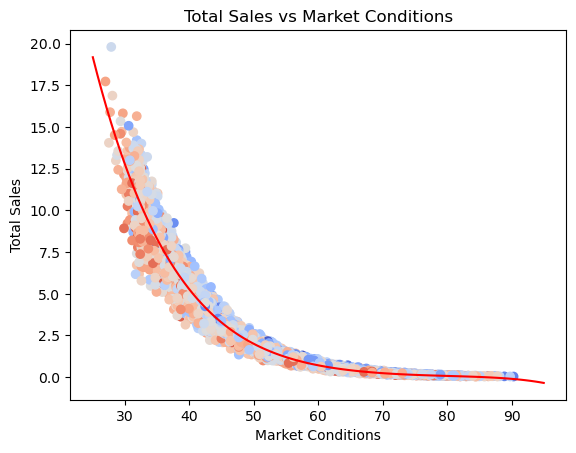

In [22]:
# Linear regression y=TS
# Note: make output_x**3 part of X
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Regression on weekends
data_to_reg = data.loc[data['bool_week_day'] == 0]

degree = 5
poly = PolynomialFeatures(degree)
output_X_poly = np.array(poly.fit_transform(data_to_reg['output_X'].values.reshape(-1, 1)))

X = np.concatenate((output_X_poly[:, 1:], data_to_reg['output_own_price'].values.reshape(-1, 1), data_to_reg['output_comp_price'].values.reshape(-1, 1)), axis=1)
y = data_to_reg['total_sales']

reg_weekends = LinearRegression().fit(X, y)

print('Intercept: ', reg_weekends.intercept_)
print('Coefficients: ', reg_weekends.coef_)
print('R^2: ', reg_weekends.score(X, y))

# Plot
data_to_plot = data.loc[data['bool_week_day'] == 0]

plt.scatter(data_to_plot['output_X'], data_to_plot['total_sales'], c=data_to_plot['output_own_price'], cmap='coolwarm')

plt.xlabel('Market Conditions')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Market Conditions')

line = np.linspace(25, 95, 100)
plt.plot(line, reg_weekends.intercept_ + np.sum([reg_weekends.coef_[i]*line**(i+1) for i in range(degree)],axis=0) + reg_weekends.coef_[degree]*data_to_plot['output_own_price'].mean() + reg_weekends.coef_[degree+1]*data_to_plot['output_comp_price'].mean(), 'r')

In [23]:
# Works amazing!

cost = 6.07
price_comp = 6.68
def profit_function(p1, p2, c, weekday, mkt_cond):
    if weekday:
        degree = 6
        ts = reg_weekdays.intercept_ + np.sum([reg_weekdays.coef_[i]*mkt_cond**(i+1) for i in range(degree)],axis=0) + reg_weekdays.coef_[degree]*p1 + reg_weekdays.coef_[degree+1]*p2
        mu = 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[1] + (results_mle.x[2] + results_mle.x[3]) * (p1 - p2))))

    else:
        degree = 5
        ts = reg_weekends.intercept_ + np.sum([reg_weekends.coef_[i]*mkt_cond**(i+1) for i in range(degree)],axis=0) + reg_weekends.coef_[degree]*p1 + reg_weekends.coef_[degree+1]*p2
        mu = 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[2] * (p1 - p2))))
    
    return - (p1 - c) * mu * ts

params_init = np.array([cost+0.001])
cons = ({'type': 'ineq', 'fun': lambda x: x[0] - cost})
result = opt.minimize(profit_function, params_init, args=(price_comp, cost, 0, 44.06), constraints=cons)

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1877544858998785
       x: [ 6.842e+00]
     nit: 5
     jac: [ 1.429e-03]
    nfev: 12
    njev: 5

In [31]:
# Compare model 2 with data
data_point = data.iloc[1]

# Get inputs
cost = data_point['output_own_cost']
price_comp = data_point['output_comp_price']
mkt_cond = data_point['output_X']
weekday = data_point['bool_week_day']

# Get model 2 prediction
params_init = np.array([cost+0.001])
cons = ({'type': 'ineq', 'fun': lambda x: x[0] - cost})
price_optimisation = opt.minimize(profit_function, params_init, args=(price_comp, cost, weekday, mkt_cond), constraints=cons)

# Get mu 
if weekday:
    mu = 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[1] + (results_mle.x[2] + results_mle.x[3]) * (price_optimisation.x[0] - price_comp))))
else:
    mu = 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[2] * (price_optimisation.x[0] - price_comp))))

# Print results
print('Predicted Share and Price Difference: ', mu, price_optimisation.x[0] - price_comp)
print('Actual Share and Price Difference: ', data_point['output_own_share'], data_point['price_diff'])
print('Optimal price: ', price_optimisation.x[0])
print('Actual price: ', data_point['output_own_price'])
print('Optimal profit: ', -price_optimisation.fun)
print('Actual profit: ', data_point['output_own_profits'])

Predicted Share and Price Difference:  0.37535514286858457 0.9755280238705124
Actual Share and Price Difference:  0.5570819 -0.0600000000000005
Optimal price:  8.085528023870513
Actual price:  7.05
Optimal profit:  26.503314469853983
Actual profit:  24.31


# Predicting P2

In [25]:
reg_comp = LinearRegression().fit(data_to_plot['output_X'].values.reshape(-1, 1), data_to_plot['output_comp_price'].values.reshape(-1, 1))

In [26]:
reg_comp.coef_

array([[-0.00065172]])

In [27]:
data_to_plot = data.loc[(data['bool_week_day'] == 1) & (data['mkt_id'] == 15555)]


X = pd.concat((data['bool_week_day'],data['output_X'], data['output_X']*data['bool_week_day']), axis=1)
y = data['output_comp_price']

X.columns = X.columns.astype(str)
reg_comp = LinearRegression().fit(X, y)


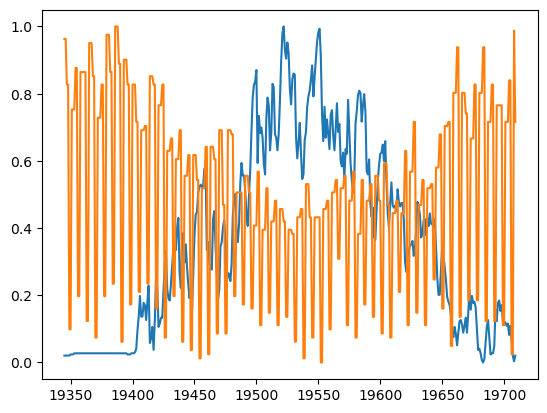

In [28]:
data_to_plot = data.loc[(data['mkt_id'] == 15555)]

plt.plot(data_to_plot['output_X'].apply(lambda x: (x - data_to_plot['output_X'].min()) / (data_to_plot['output_X'].max() - data_to_plot['output_X'].min())))
plt.plot(abs(data_to_plot['output_comp_price']).apply(lambda x: (x - data_to_plot['output_comp_price'].min()) / (data_to_plot['output_comp_price'].max() - data_to_plot['output_comp_price'].min())))
# plt.plot(data_to_plot['output_own_price'].apply(lambda x: (x - data_to_plot['output_own_price'].min()) / (data_to_plot['output_own_price'].max() - data_to_plot['output_own_price'].min())))

line = np.linspace(0, 365, 261)
#plt.plot(line, reg_comp.intercept_ + reg_comp.coef_[0]*data_to_plot['output_X'], 'r')

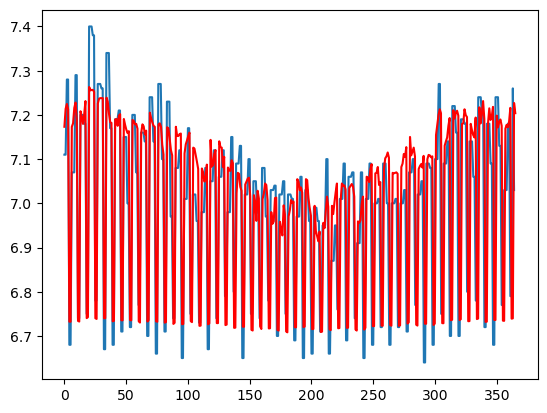

In [29]:
data_to_plot = data.loc[(data['mkt_id'] == 44)]

line = np.linspace(0, 365, 365)
plt.plot(data_to_plot['output_comp_price'])
plt.plot(line, reg_comp.intercept_ + reg_comp.coef_[0]*data_to_plot['bool_week_day'] + reg_comp.coef_[1]*data_to_plot['output_X'] + reg_comp.coef_[2]*data_to_plot['bool_week_day']*data_to_plot['output_X'], 'r')

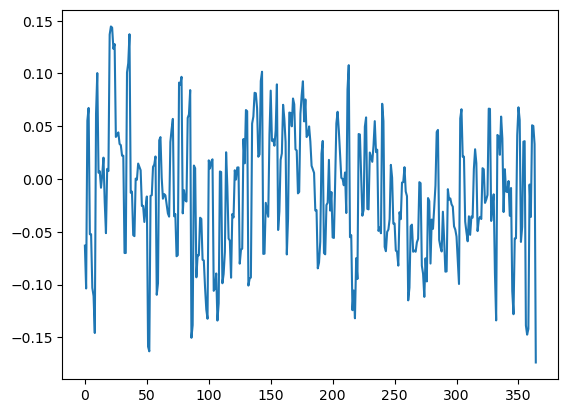

In [30]:
plt.plot(data_to_plot['output_comp_price'] - (reg_comp.intercept_ + reg_comp.coef_[0]*data_to_plot['bool_week_day'] + reg_comp.coef_[1]*data_to_plot['output_X'] + reg_comp.coef_[2]*data_to_plot['bool_week_day']*data_to_plot['output_X']))